In [2]:
import pandas as pd
import numpy as np
from io import StringIO

In [3]:
# Create an example dataframe
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

## Removing NaN Values

In [4]:
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [5]:
# Look at the number of null values in each column
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [6]:
# Drop rows with missing values
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# Drop columns with missing values
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [8]:
# Drop rows where all columns are NaN
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [9]:
# Drop rows that have fewer than 4 real values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [10]:
# Only drop rows where NaN appear in specific columns (here: 'C')
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


## Imputing Missing Values

In [11]:
# Mean Imputation
# Inputting missing values with the mean of the entire feature column
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [12]:
# can also do this just with pandas
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


## Handling Categorical Data

In [13]:
# Categorical Data encoding with pandas
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1']
])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


In [14]:
# Mapping ordinal features
size_mapping = {
    'XL': 3,
    'L': 2,
    'M': 1
}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [15]:
# Encoding class labels
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [16]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [17]:
# Nominal label encoding using sklearn encoder
from sklearn.preprocessing import LabelEncoder
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [18]:
# One-hot incoding nominal features (to avoid ordinality)
from sklearn.preprocessing import OneHotEncoder
X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [19]:
# transform the columns of our data frame
from sklearn.compose import ColumnTransformer
X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [1, 2])
])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [20]:
# or just use pandas get_dummies method
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


## Sequential Feature Selection Algorithms

In [21]:
# My Implementation of Sequential Backward Selection
from tqdm import tqdm
"""
Sequential Backward Selection (SBS) is a feature selection algorithm that
removes features from the feature set until the new feature subspace contains
the desired number of features.

Steps are as follows:
1. Initialize the algorithm with k = d, where d is the dimensionality of the
    full feature space X_d.
2. Determine the feature x^− that maximizes the criterion x^− = argmax J(X_k − x)
3. Remove the feature x^− from the feature set: X_k−1 = X_k − x^−; k = k − 1
4. Terminate if k equals the number of desired features; otherwise, go to step 2.
"""
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from itertools import combinations

class SBS:
    
    def __init__(self, estimator, k_features, metric=accuracy_score):
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.metric = metric
    
    def fit(self, X, y):
        # get name of features
        self.features_ = X.columns.tolist()
        feature_subsets = list(combinations(self.features_, self.k_features))
        
        acc = np.zeros(len(feature_subsets))
        for idx, feature_subset in tqdm(enumerate(feature_subsets), ascii=True, desc='SBS'):
            #print(list(feature_subset))
            self.estimator.fit(X.loc[:, list(feature_subset)], y)
            y_pred = self.estimator.predict(X.loc[:, list(feature_subset)])
            acc[idx] = self.metric(y, y_pred)
        
        self.indices_ = feature_subsets[np.argmax(acc)]
        self.accuracy_ = np.max(acc)
        
        return self
    
    def transform(self, X):
        return X.loc[:, self.indices_]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [28]:
# Load the wine dataset
from sklearn.datasets import load_wine
wine_dataset = load_wine()
df_wine = pd.DataFrame(wine_dataset.data, columns=wine_dataset.feature_names)
df_wine

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [23]:
# Min-max scaling
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(df_wine)
df_wine_norm = pd.DataFrame(mms.transform(df_wine), columns=wine_dataset.feature_names)
df_wine_norm.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


In [24]:
df_wine_norm.loc[:, ['alcohol', 'malic_acid', 'ash']]

,alcohol,malic_acid,ash
0,0.842105,0.191700,0.572193
1,0.571053,0.205534,0.417112
2,0.560526,0.320158,0.700535
3,0.878947,0.239130,0.609626
4,0.581579,0.365613,0.807487
...,...,...,...
173,0.705263,0.970356,0.582888
174,0.623684,0.626482,0.598930
175,0.589474,0.699605,0.481283
176,0.563158,0.365613,0.540107


In [25]:
from sklearn.linear_model import LogisticRegression
sbs_model = SBS(estimator=LogisticRegression(), k_features=3)
print(type(df_wine_norm))
sbs_model.fit(df_wine_norm, wine_dataset.target)
sbs_model.indices_, sbs_model.accuracy_

<class 'pandas.core.frame.DataFrame'>


SBS: 28it [00:00, 274.18it/s]

SBS: 286it [00:00, 318.28it/s]


(('flavanoids', 'color_intensity', 'proline'), 0.9606741573033708)

## Assessing Feature Importance with Random Forests

RANKING OF COLUMNS!
 1) Proline                        0.213565
 2) Flavanoids                     0.166822
 3) Color intensity                0.140178
 4) OD280/OD315 of diluted wines   0.121524
 5) Alcohol                        0.109104
 6) Hue                            0.059554
 7) Total phenols                  0.050360
 8) Alcalinity of ash              0.032400
 9) Magnesium                      0.027268
10) Malic acid                     0.025183
11) Proanthocyanins                0.024799
12) Nonflavanoid phenols           0.017587
13) Ash                            0.011656


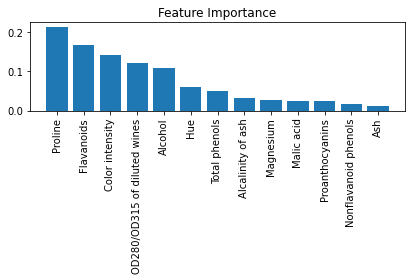

In [56]:
# Get the feature importance of the data from an attribute
# given by a fitted RandomForestClassifier
import matplotlib.pyplot as plt

# Load the data
from sklearn.model_selection import train_test_split


df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data')
df_wine.columns = ['Class label', 'Alcohol',
    'Malic acid', 'Ash',
    'Alcalinity of ash', 'Magnesium',
    'Total phenols', 'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines',
    'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Create model
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)

# Now that we have initilized the RFC, fit and print out the importances
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1] # Descending sort

print("RANKING OF COLUMNS!")
for rank, index in enumerate(indices):
    print("%2d) %-*s %f" % (rank+1, 30, feat_labels[index], importances[index]))

# Plot findings
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()


NOTE: If there are two highly correlated features, then one of the values
might have a significantly higher importance than the other!